<a href="https://www.kaggle.com/code/krishnaprasad2608/time-series-pytorch?scriptVersionId=172229159" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1)Taking a glance at the data

In [1]:
import pandas as pd
from prettytable import PrettyTable
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv('/kaggle/input/weather-data/weatherdata.csv', sep=';')
df.columns = df.columns.str.strip() 
df.head()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,3379,19540601,-999,-999.0,-999.0,1,0.0,1,-999.0,0,-999.0,-999.0,-999.0,14.0,-999.0,17.6,10.4,-999.0,eor
1,3379,19540602,-999,-999.0,-999.0,1,0.5,1,-999.0,0,-999.0,-999.0,-999.0,13.2,-999.0,19.7,9.7,-999.0,eor
2,3379,19540603,-999,-999.0,-999.0,1,0.0,1,-999.0,0,-999.0,-999.0,-999.0,16.6,-999.0,21.9,8.2,-999.0,eor
3,3379,19540604,-999,-999.0,-999.0,1,1.2,1,-999.0,0,-999.0,-999.0,-999.0,15.2,-999.0,17.3,11.8,-999.0,eor
4,3379,19540605,-999,-999.0,-999.0,1,6.0,1,-999.0,0,-999.0,-999.0,-999.0,15.2,-999.0,17.7,13.7,-999.0,eor


In [3]:
# Displaying basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25051 entries, 0 to 25050
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STATIONS_ID  25051 non-null  int64  
 1   MESS_DATUM   25051 non-null  int64  
 2   QN_3         25051 non-null  int64  
 3   FX           25051 non-null  float64
 4   FM           25051 non-null  float64
 5   QN_4         25051 non-null  int64  
 6   RSK          25051 non-null  float64
 7   RSKF         25051 non-null  int64  
 8   SDK          25051 non-null  float64
 9   SHK_TAG      25051 non-null  int64  
 10  NM           25051 non-null  float64
 11  VPM          25051 non-null  float64
 12  PM           25051 non-null  float64
 13  TMK          25051 non-null  float64
 14  UPM          25051 non-null  float64
 15  TXK          25051 non-null  float64
 16  TNK          25051 non-null  float64
 17  TGK          25051 non-null  float64
 18  eor          25051 non-null  object 
dtypes: f

In [4]:
#  summary statistics 
df.describe()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK
count,25051.0,2.505100e+04,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000,25051.000000
mean,3379.0,1.988272e+07,-440.069458,-443.776775,-446.922051,5.661530,2.627951,2.686679,-7.370731,-61.539899,-443.378979,-440.455842,83.229992,9.612083,-405.123415,13.828729,5.658369,-443.437691
std,0.0,1.980004e+05,501.479739,501.633240,498.138980,4.318503,5.911350,2.880991,110.177292,242.190168,499.278507,501.344036,971.398000,7.908055,533.140985,9.013736,7.036732,499.129425
min,3379.0,1.954060e+07,-999.000000,-999.000000,-999.000000,1.000000,0.000000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-20.000000,-999.000000,-17.900000,-25.400000,-999.000000
25%,3379.0,1.971072e+07,-999.000000,-999.000000,-999.000000,1.000000,0.000000,0.000000,0.400000,0.000000,-999.000000,-999.000000,-999.000000,3.400000,-999.000000,6.700000,0.500000,-999.000000
50%,3379.0,1.988092e+07,10.000000,4.900000,1.200000,9.000000,0.000000,1.000000,3.900000,0.000000,1.300000,4.700000,945.000000,9.900000,54.000000,14.200000,5.900000,-4.200000
75%,3379.0,2.005111e+07,10.000000,8.900000,2.400000,10.000000,2.600000,6.000000,8.300000,0.000000,6.200000,9.500000,956.400000,15.800000,76.000000,20.900000,11.400000,6.200000
max,3379.0,2.022123e+07,10.000000,38.600000,11.000000,10.000000,101.600000,8.000000,15.717000,55.000000,8.000000,21.500000,979.600000,30.400000,100.000000,37.500000,22.600000,21.400000


In [5]:
# no. of rows and columns
df.shape

(25051, 19)

# 2)Preprocessing

In [6]:
# Defining a list of columns to drop
columns_to_drop = ['STATIONS_ID', 'eor', 'QN_3', 'QN_4', 'TXK', 'TNK', 'TGK']

# Dropping the specified columns 
df.drop(columns=columns_to_drop, inplace=True)


In [7]:
# Converting MESS_DATUM to date
df['MESS_DATUM'] = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d')


In [8]:
# Replace -999 values with NaN
df = df.replace(-999, np.nan)

In [9]:
num_features = df._get_numeric_data().columns

In [10]:
#Missing values

# Create an empty list to store data for each row
table_data = []

for column in df.columns:
    data_type = str(df[column].dtype)
    missing_percentage = round(100 - (df[column].count() / len(df)) * 100, 1)
    # Append the data for the current column to the table data list
    table_data.append([column, data_type, missing_percentage])

# Create a DataFrame from the table data
table_df = pd.DataFrame(table_data, columns=['Feature', 'Data Type', 'Data Missing %'])

# Print the DataFrame
print(table_df)


       Feature       Data Type  Data Missing %
0   MESS_DATUM  datetime64[ns]             0.0
1           FX         float64            44.9
2           FM         float64            44.9
3          RSK         float64             0.0
4         RSKF           int64             0.0
5          SDK         float64             1.2
6      SHK_TAG         float64             6.3
7           NM         float64            44.7
8          VPM         float64            44.6
9           PM         float64            44.6
10         TMK         float64             0.0
11         UPM         float64            44.6


In [11]:
import warnings
warnings.filterwarnings('ignore')

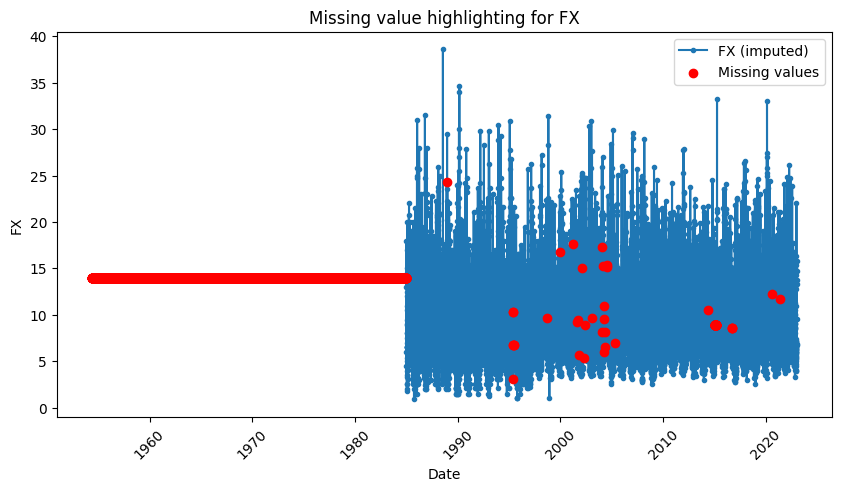

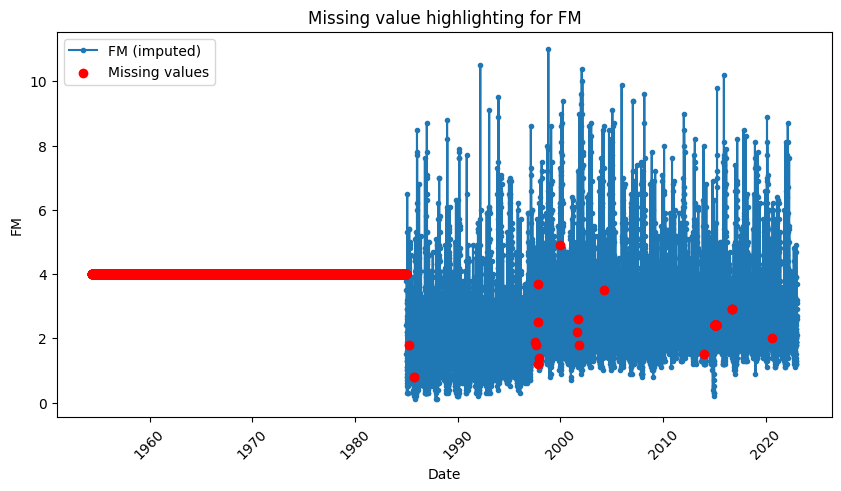

In [12]:
import matplotlib.pyplot as plt

missing_cols = ['FX', 'FM']

for column in missing_cols:
    if column != 'MESS_DATUM':
        # Extract data for the current column
        bfm = df[['MESS_DATUM', column]].copy()
        bfm.set_index('MESS_DATUM', inplace=True)
        
        # Fill missing values using backward fill 
        bfm_imputed = bfm.fillna(method='bfill')
        
        # Plot original and imputed data
        plt.figure(figsize=[10, 5])
        plt.plot(bfm_imputed.index, bfm_imputed[column], linestyle="-", marker=".", label=f'{column} (imputed)')
        plt.scatter(bfm_imputed.index[bfm[column].isnull()], bfm_imputed[column][bfm[column].isnull()], color='r', label='Missing values', zorder=5)
        
        # Set title and labels
        plt.title(f'Missing value highlighting for {column}')
        plt.xlabel('Date')
        plt.ylabel(column)
        plt.legend()
        plt.xticks(rotation=45)
        
        # Show plot
        plt.show()

It is clear from looking at the charts above that there is a significant lack of data in several columns prior to 1985. Therefore, we will concentrate on data starting in 1985 in order to maintain the accuracy 

In [13]:
# Filter df 
df = df[df['MESS_DATUM'] >= '1985-01-01']

In [14]:
# Use backward fill 
df = df.fillna(method='bfill')


All the missing values are now handled

In [15]:
# Add new columns to df
df = df.assign(YEAR=df['MESS_DATUM'].dt.year,
               MONTH=df['MESS_DATUM'].dt.month,
               DAY=df['MESS_DATUM'].dt.day,
               DAY_OF_YEAR=df['MESS_DATUM'].dt.dayofyear,
               WEEK_OF_YEAR=df['MESS_DATUM'].dt.isocalendar().week,
               QUARTER=df['MESS_DATUM'].dt.quarter)


In [16]:
df = df.drop(columns=['SDK', 'FX', 'DAY', 'MONTH', 'DAY_OF_YEAR', 'WEEK_OF_YEAR', 'QUARTER'])

# 3)Splitting the data

In [17]:
X = df
y = df['TMK']

In [18]:
mm = MinMaxScaler()
X_scaled = mm.fit_transform(X.drop(columns=['MESS_DATUM']))
y_scaled = mm.fit_transform(y.values.reshape(-1, 1))

In [19]:
from sklearn.model_selection import train_test_split

# Split the scaled features and scaled target
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.025, random_state=42)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13532, 10), (347, 10), (13532, 1), (347, 1))

# 4)processing

In [21]:
class WeatherDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.target = torch.tensor(target, dtype=torch.float32)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

The WeatherDataset class initializes with features and target data, converting them into PyTorch tensors. It provides methods to retrieve dataset length and individual samples, returning tuples of features and corresponding targets. 

In [22]:
# Creating custom datasets for training and testing
train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

In [23]:
class CustomNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(p=0.8)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

The CustomNet class defines a neural network with two fully connected layers, incorporating ReLU activation and dropout regularization to process input data and produce output predictions.

In [24]:
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 0.01
INPUT_SIZE = X_train.shape[1]
HIDDEN_SIZE = 30
OUTPUT_SIZE= 1
EVAL_STEP = 1

In [25]:
# Create dataloaders 
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
net = CustomNet(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE)

In [27]:
print('Starting Training:')
train_losses = []
test_losses = []

for epoch in range(EPOCHS):
    net.train()
    epoch_train_loss = []
    for idx, data in enumerate(train_loader):
        features, target = data
        optimizer.zero_grad()
        outputs = net(features)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        epoch_train_loss.append(loss.item())
    
    # Compute train loss
    train_loss = np.mean(epoch_train_loss)
    train_losses.append(train_loss)

    # Evaluate on the test set
    net.eval()
    epoch_test_loss = []
    with torch.no_grad():
        for idx, data in enumerate(test_loader):
            features, target = data
            outputs = net(features)
            loss = criterion(outputs, target)
            epoch_test_loss.append(loss.item())
    
    # Compute test loss
    test_loss = np.mean(epoch_test_loss)
    test_losses.append(test_loss)

    # Print epoch information
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f}')
    print(f'Epoch: {epoch} | Test Loss: {test_loss:.5f}')

Starting Training:
Epoch: 0 | Train Loss: 0.03700
Epoch: 0 | Test Loss: 0.02029
Epoch: 1 | Train Loss: 0.02192
Epoch: 1 | Test Loss: 0.01825
Epoch: 2 | Train Loss: 0.02040
Epoch: 2 | Test Loss: 0.01559
Epoch: 3 | Train Loss: 0.01811
Epoch: 3 | Test Loss: 0.01207
Epoch: 4 | Train Loss: 0.01645
Epoch: 4 | Test Loss: 0.01049
Epoch: 5 | Train Loss: 0.01572
Epoch: 5 | Test Loss: 0.00972
Epoch: 6 | Train Loss: 0.01499
Epoch: 6 | Test Loss: 0.00896
Epoch: 7 | Train Loss: 0.01449
Epoch: 7 | Test Loss: 0.00831
Epoch: 8 | Train Loss: 0.01437
Epoch: 8 | Test Loss: 0.00782
Epoch: 9 | Train Loss: 0.01380
Epoch: 9 | Test Loss: 0.00759
Epoch: 10 | Train Loss: 0.01358
Epoch: 10 | Test Loss: 0.00698
Epoch: 11 | Train Loss: 0.01318
Epoch: 11 | Test Loss: 0.00680
Epoch: 12 | Train Loss: 0.01326
Epoch: 12 | Test Loss: 0.00669
Epoch: 13 | Train Loss: 0.01255
Epoch: 13 | Test Loss: 0.00629
Epoch: 14 | Train Loss: 0.01257
Epoch: 14 | Test Loss: 0.00628
Epoch: 15 | Train Loss: 0.01250
Epoch: 15 | Test Loss: 0


This script conducts training and evaluation loops for a neural network (net). It iterates over epochs, optimizing the model with training data and computing losses. After each epoch, it evaluates the model on test data, recording training and test losses. It prints epoch-wise training and test losses. train_losses and test_losses lists store respective losses for visualization, providing insight into the model's performance over training epochs.

50 epochs make up the training phase, which progressively lowers test and training losses. Losses reduce quickly at first, then converge to lower values with slight improvements. The model's capacity to generalize successfully is suggested by the decreasing test loss, which also validates the model's successful training by showing effective learning and performance on unknown data.

In [28]:
def evaluation(dataloader, loss_function, model):
    model.eval()
    y_pred = []
    y_true = []

    for idx, data in enumerate(dataloader):
        features, target = data
        y_pred.extend(model(features).data.numpy())
        y_true.extend(target.numpy())

    return y_pred, y_true

In [29]:
# Run the prediction
y_pred_scaled, y_real_scaled = evaluation(test_loader, criterion, net)

In [30]:
y_pred = mm.inverse_transform(y_pred_scaled)
y_real = mm.inverse_transform(y_real_scaled)

temp_df = pd.DataFrame(np.hstack((y_pred, y_real)))
temp_df.columns = ['Prediction', 'Real']
print(f'MAE: {mean_absolute_error(temp_df["Prediction"], temp_df["Real"])}')
print(f'MSE: {mean_squared_error(temp_df["Prediction"], temp_df["Real"])}')

MAE: 2.5456502875608398
MSE: 9.160174328236712


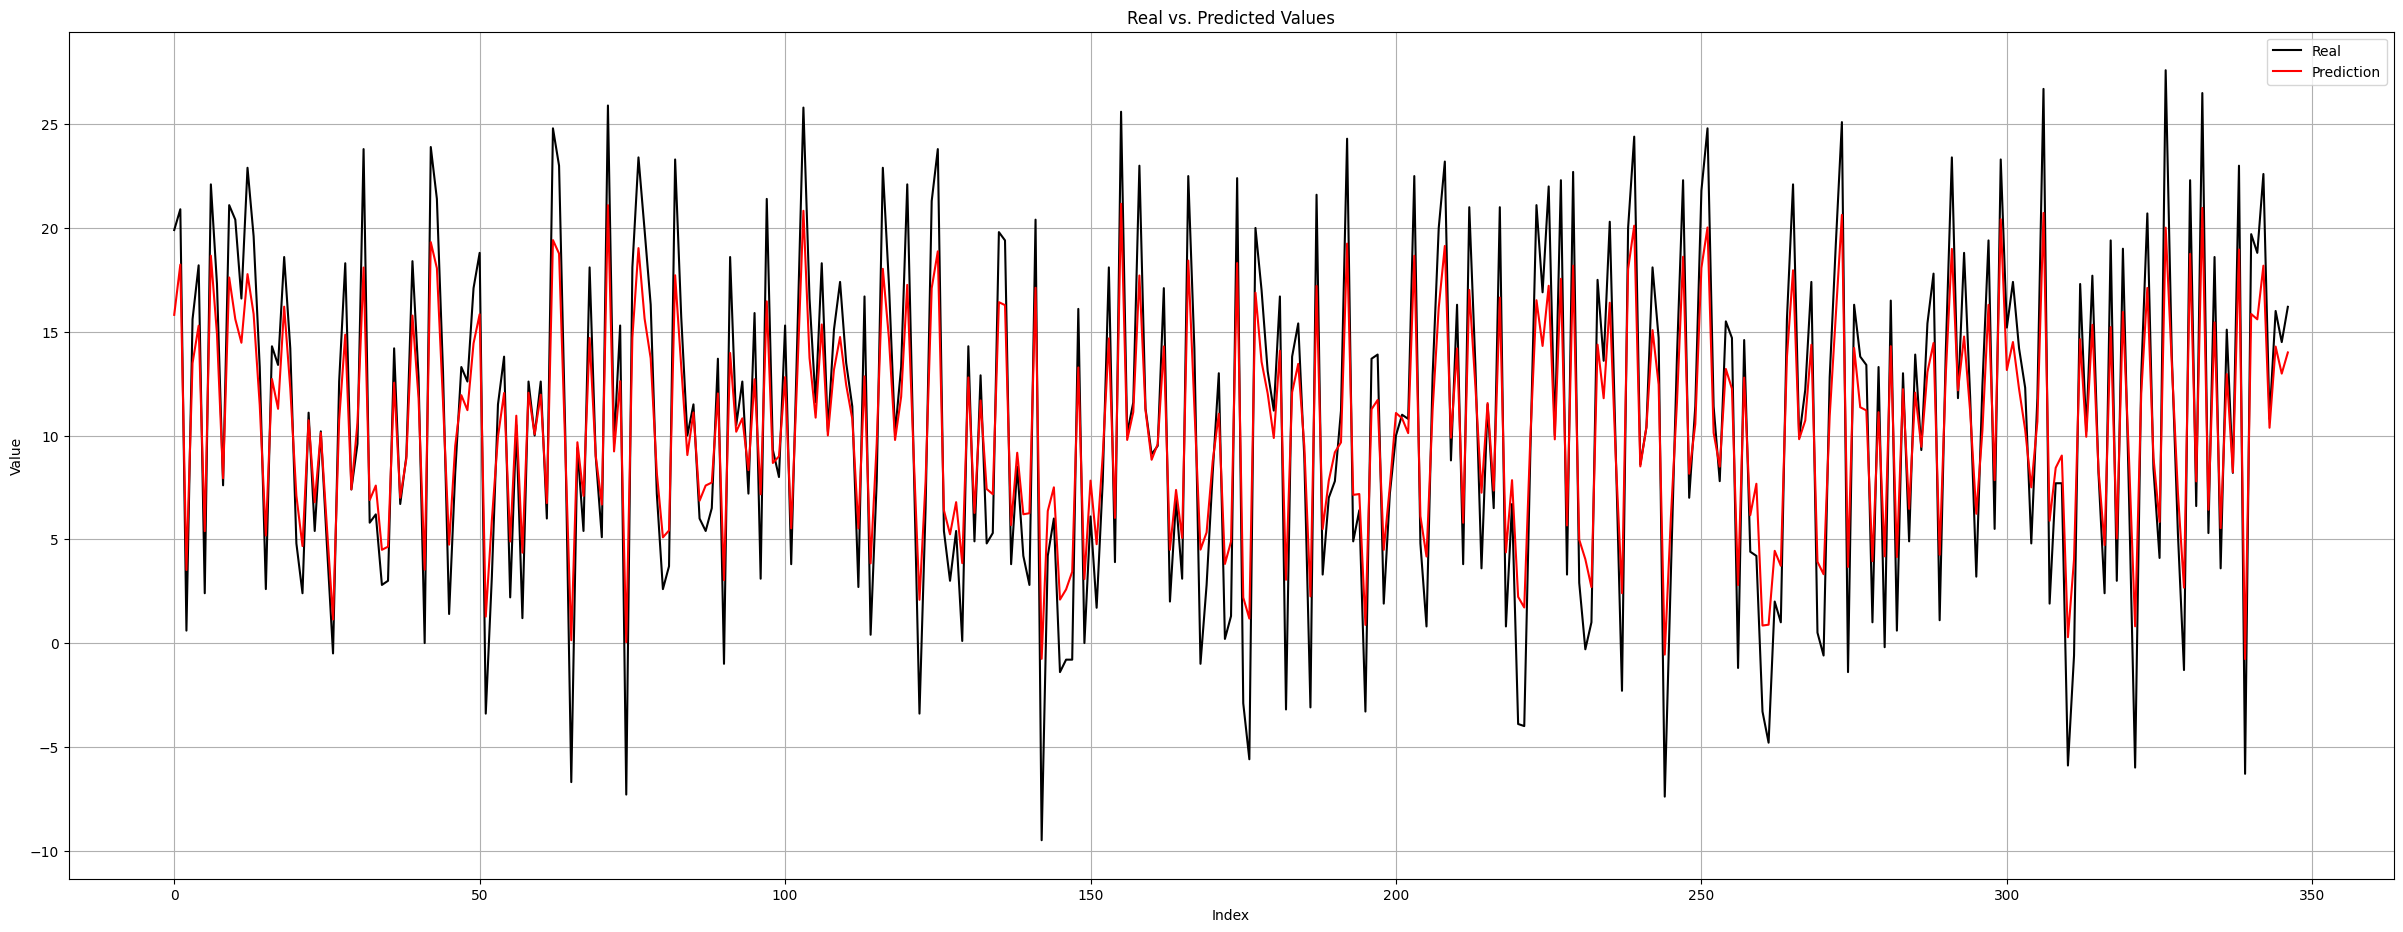

In [31]:
import matplotlib.pyplot as plt


plt.figure(figsize=(30, 11))
plt.plot(temp_df['Real'], color='black', label='Real')
plt.plot(temp_df['Prediction'], color='red', label='Prediction')
plt.title('Real vs. Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Model 2

In [32]:
# Split the scaled features and scaled target 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.025, random_state=42)

In [33]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# Assuming you have X_train, X_test, y_train, and y_test already defined

# Convert data to tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
y_test = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))

In [34]:
# Define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

This code defines an LSTM neural network model in PyTorch. The __init__ method initializes the model with input size, hidden size, number of layers, and output size. It sets up an LSTM layer and a fully connected layer. The forward method performs the forward pass. It initializes hidden and cell states, passes input through the LSTM layer, selects the output from the last time step, and passes it through the fully connected layer. The model aims to process sequential data, such as time series , to predict or classify outcomes based on learned patterns in the input sequence.

In [35]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_layers = 2
hidden_size = 64
input_size = X_train.shape[1]
output_size = 1
learning_rate = 0.003
num_epochs = 10
batch_size = 128

In [36]:
# Create model instance
model = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size).to(device)

This line instantiates an LSTM model with specified parameters (input_size, hidden_size, num_layers, output_size) and moves it to a designated device (device) for computation.

In [37]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

This code sets up the loss function (criterion) as Mean Squared Error (MSE) and the optimizer (optimizer) as Adam, which updates the model's parameters based on gradients with a specified learning rate (learning_rate).

In [38]:
# Data loaders
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [39]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.view(-1, inputs.shape[1] // input_size, input_size).to(device)
        targets = targets.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.view(-1, inputs.shape[1] // input_size, input_size).to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")


Epoch [1/10], Train Loss: 0.0317, Test Loss: 0.0017
Epoch [2/10], Train Loss: 0.0008, Test Loss: 0.0006
Epoch [3/10], Train Loss: 0.0004, Test Loss: 0.0003
Epoch [4/10], Train Loss: 0.0003, Test Loss: 0.0002
Epoch [5/10], Train Loss: 0.0002, Test Loss: 0.0001
Epoch [6/10], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [7/10], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [8/10], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [9/10], Train Loss: 0.0000, Test Loss: 0.0000
Epoch [10/10], Train Loss: 0.0000, Test Loss: 0.0000


The training loop iterates over epochs, optimizing the LSTM model. It trains on batches from train_loader, calculating MSE loss, and updating parameters via backpropagation. After each epoch, it evaluates performance on the validation set from test_loader, computing and printing average training and validation losses.

The model has been trained for ten epochs. With each period, test and training losses decreased from their initial rather high levels. Losses converged to incredibly low values by the ninth and tenth epochs, demonstrating the model's ability of learning and generalization and indicating little error in predictions.

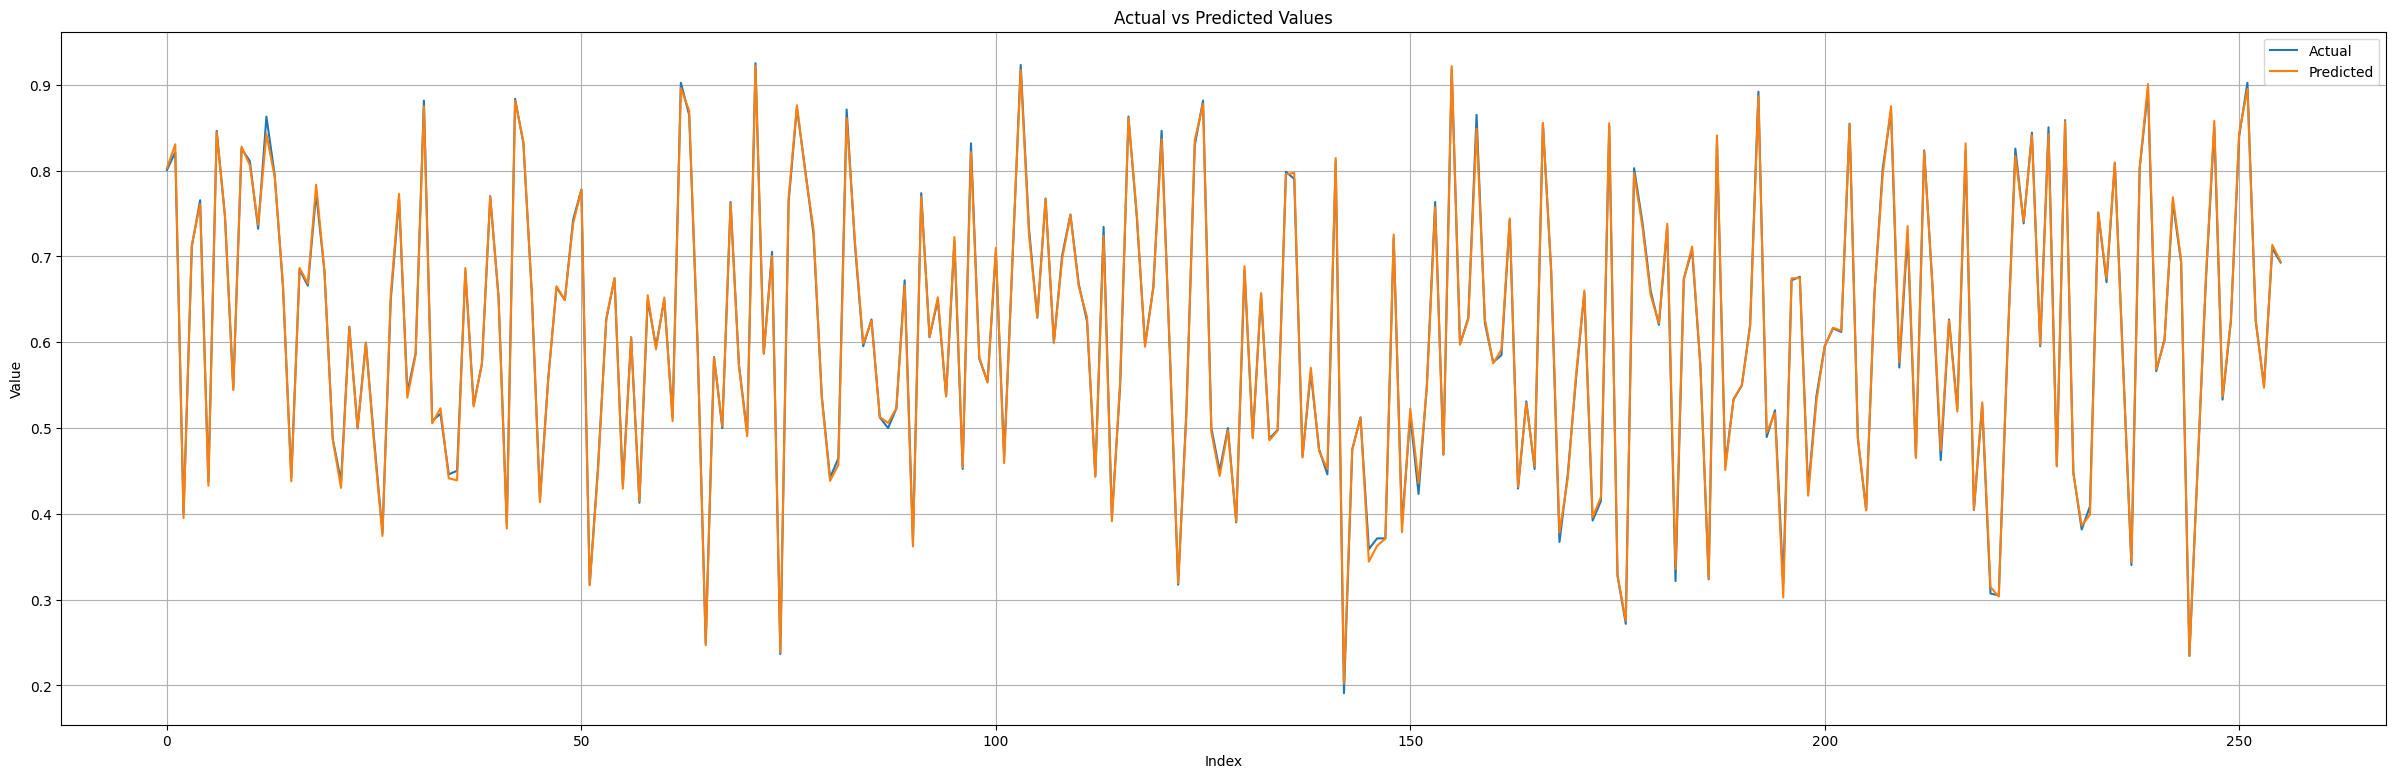

In [40]:
import matplotlib.pyplot as plt

# Lists to store actual and predicted values
actual_values = []
predicted_values = []

# Testing loop with prediction storage
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.view(-1, inputs.shape[1] // input_size, input_size).to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        
        # Append actual and predicted values
        actual_values.extend(targets.cpu().numpy())
        predicted_values.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays
actual_values = np.array(actual_values)
predicted_values = np.array(predicted_values)

# Plot actual vs predicted values
plt.figure(figsize=(30, 9))
plt.plot(actual_values, label='Actual')
plt.plot(predicted_values, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()
